# **Question 1**

In [1]:
#imports and downloads required in this project
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
!pip install surprise
from surprise import Dataset, Reader, accuracy
from surprise.model_selection import cross_validate
from surprise.prediction_algorithms.knns import KNNWithMeans
from surprise.model_selection import cross_validate, KFold, train_test_split
from pathlib import Path
from surprise.model_selection import cross_validate, KFold, train_test_split
from sklearn.metrics import roc_curve, auc, mean_squared_error
from surprise.prediction_algorithms.matrix_factorization import NMF, SVD

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 14.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3163018 sha256=8cda9d7336a43d45ccc057b30bf05b3df2127baaae1c17c07adf0ffe29a350ff
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [2]:
#mounting the drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#Reading the csv from drive and storing it in a dataframe
ratings=pd.read_csv('gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/Project 3/Synthetic_Movie_Lens/ratings.csv',usecols=['userId','movieId','rating'])
ratings.shape

(100836, 3)

In [ ]:
#Checking the columns in the file
ratings.columns

Index(['userId', 'movieId', 'rating'], dtype='object')

In [ ]:
ratings.head()

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5


In [ ]:
#Finding the sparsity of the movie rating dataset
userIds = ratings.pop('userId').values
movieIds = ratings.pop('movieId').values
ratingsGiven = ratings.pop('rating').values
sparsity = len(ratingsGiven)/(len(set(movieIds))*len(set(userIds)))
print('Sparsity:',sparsity)

Sparsity: 0.016999683055613623


Text(0.5, 1.0, 'Frequency of rating values')

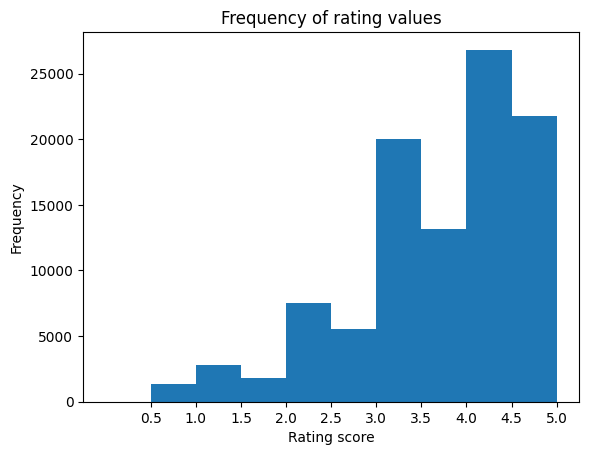

In [ ]:
#Plotting the graph of frequency of rating values
bins = np.linspace(0,5,num=11)
plt.hist(ratingsGiven,bins=bins)
plt.xticks(np.arange(0.5, 5.1, step=0.5))
plt.xlabel("Rating score");
plt.ylabel("Frequency");
plt.title("Frequency of rating values")

Text(0.5, 1.0, 'Number of ratings received against movies')

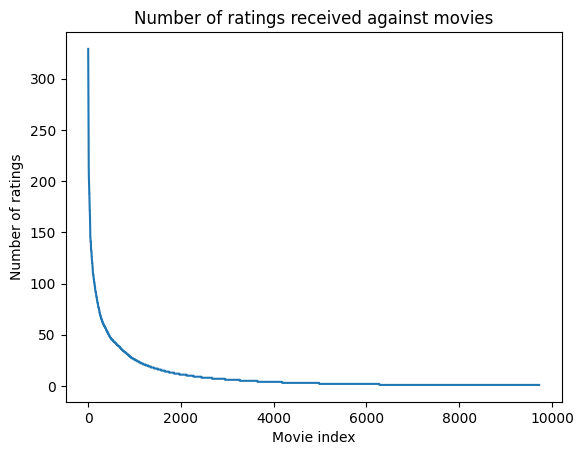

In [ ]:
#Plotting the graph of number of ratings received against movie
noOfMovies = Counter(movieIds)
num_ratings = sorted(list(noOfMovies.values()),reverse=True)
plt.plot(num_ratings)
plt.xlabel("Movie index");
plt.ylabel("Number of ratings");
plt.title("Number of ratings received against movies")

Text(0.5, 1.0, 'Number of ratings among users')

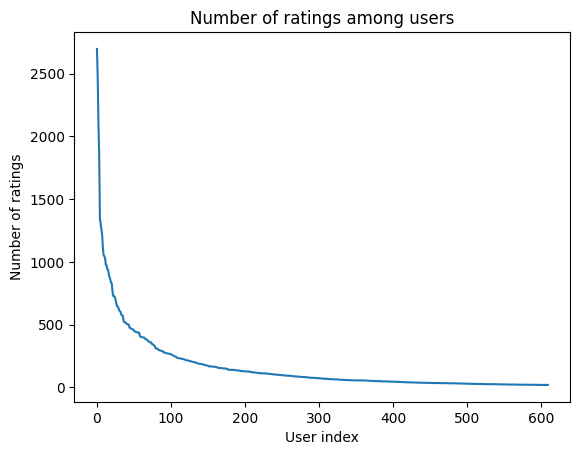

In [ ]:
#Plotting a graph of number of ratings among users
countOfUserIds = Counter(userIds)
num_users = sorted(list(countOfUserIds.values()),reverse=True)
plt.plot(num_users)
plt.xlabel("User index");
plt.ylabel("Number of ratings");
plt.title("Number of ratings among users")

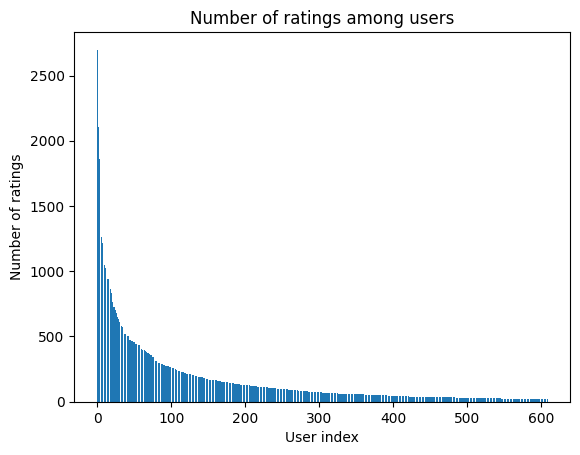

In [ ]:
#Plotting a bar graph of number of ratings among users
countOfUserIds = Counter(userIds)

# Sort the counts in descending order
num_users = sorted(list(countOfUserIds.values()), reverse=True)

# Plot the bar graph
plt.bar(range(len(num_users)), num_users)
plt.xlabel("User index");
plt.ylabel("Number of ratings");
plt.title("Number of ratings among users")
plt.show()

In [ ]:
#Creating the matrix R
ratings=pd.read_csv('gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/Project 3/Synthetic_Movie_Lens/ratings.csv',usecols=['userId','movieId','rating'])
unique_user_id = np.unique(ratings['userId'])
unique_movie_id = np.unique(ratings['movieId'])
matrix_r = pd.DataFrame(columns=unique_user_id)
matrix_r.insert(0,'Movie ID', '')
matrix_r['Movie ID']=unique_movie_id
for ind, row in ratings.iterrows():
  matrix_r[int(row['userId'])].iloc[list(matrix_r['Movie ID']).index(int(row['movieId']))] = row['rating']
print(matrix_r.head())
matrix_r = matrix_r.drop(matrix_r.columns[0],axis=1)
matrix_r

<ipython-input-21-3633fb6ba6c7>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matrix_r[int(row['userId'])].iloc[list(matrix_r['Movie ID']).index(int(row['movieId']))] = row['rating']


   Movie ID    1    2    3    4    5    6    7    8    9  ...  601  602  603  \
0         1  4.0  NaN  NaN  NaN  4.0  NaN  4.5  NaN  NaN  ...  4.0  NaN  4.0   
1         2  NaN  NaN  NaN  NaN  NaN  4.0  NaN  4.0  NaN  ...  NaN  4.0  NaN   
2         3  4.0  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3         4  NaN  NaN  NaN  NaN  NaN  3.0  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4         5  NaN  NaN  NaN  NaN  NaN  5.0  NaN  NaN  NaN  ...  NaN  NaN  NaN   

   604  605  606  607  608  609  610  
0  3.0  4.0  2.5  4.0  2.5  3.0  5.0  
1  5.0  3.5  NaN  NaN  2.0  NaN  NaN  
2  NaN  NaN  NaN  NaN  2.0  NaN  NaN  
3  NaN  NaN  NaN  NaN  NaN  NaN  NaN  
4  3.0  NaN  NaN  NaN  NaN  NaN  NaN  

[5 rows x 611 columns]


,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
0,4.0,NaN,NaN,NaN,4.0,NaN,4.5,NaN,NaN,NaN,...,4.0,NaN,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,...,NaN,4.0,NaN,5.0,3.5,NaN,NaN,2.0,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9720,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9721,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9722,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


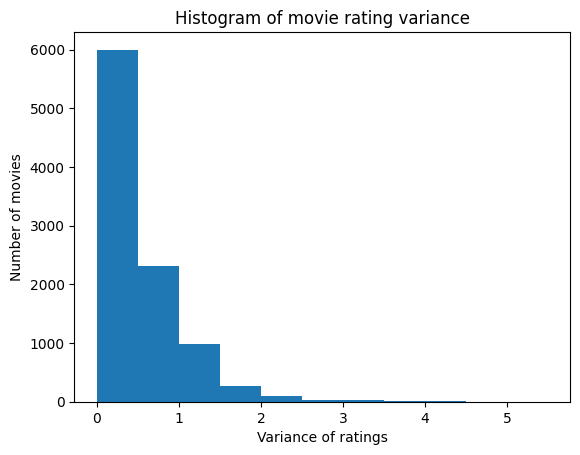

In [ ]:
# Finding the variance per movie
variance_per_movie = [np.var(matrix_r.iloc[i, 1:]) for i in range(len(matrix_r))]
# Bin the variance values into intervals of width 0.5
bin_width = 0.5
variance_bins = np.arange(0, max(variance_per_movie) + bin_width, bin_width)

# Count the number of movies in each bin
bin_counts, _ = np.histogram(list(variance_per_movie), bins=variance_bins)

# Plot the histogram
plt.bar(variance_bins[:-1], bin_counts, width=bin_width, align='edge')
plt.xlabel("Variance of ratings")
plt.ylabel("Number of movies")
plt.title("Histogram of movie rating variance")
plt.show()

QUESTION 1: Explore the Dataset: In this question, we explore the structure of the data.
Compute the sparsity of the movie rating dataset:
Sparsity = Total number of available ratings / Total number of possible ratings
> Sparsity: 0.016999683055613623
> We can see that the sparsity is low. This means that many movie ratings are missing. From the dataset, we can see that there are many movies compared to the number of users and not all the users have watched the majority of the movies. This implies that the Rating matrix R is sparse in nature.

Plot a histogram showing the frequency of the rating values: Bin the raw rating values into intervals of width 0.5 and use the binned rating values as the horizontal axis. Count the number of entries in the ratings matrix R that fall within each bin and use this count as the height of the vertical axis for that particular bin. Comment on the shape of the histogram.

> Please refer to the histogram above. From the above histogram, we can see that most of the ratings lie between 3 and 5. Very few ratings are below 3. 4 has received the most ratings. The distribution is more concentrated towards the right. We can also see that the integer values of the ratings have received more ratings as compared to the decimal values.

Plot the distribution of the number of ratings received among movies: The X-axis should be the movie index ordered by decreasing frequency and the Y -axis should be the number of ratings the movie has received; ties can be broken in any way. A monotonically decreasing trend is expected.

> Please refer to the histogram above. The curve is  monotonically decreasing as approximately 500 movies received less than 50 ratings. This confirms that the matrix R is sparse.

Plot the distribution of ratings among users: The X-axis should be the user index ordered by decreasing frequency and the Y -axis should be the number of movies the user has rated. The requirement of the plot is similar to that in Question C.

> Please refer to the histogram above. This graph is also monotonically decreasing. Only approximately 50 users have given ratings to 500 movies or more. The remaining have given ratings to less than 500 movies.

Discuss the salient features of the distributions from Questions C,D and their implications for the recommendation process.

> We can see that both the graphs are monotonically decreasing in nature. For the number of ratings against movies, we notice that the curve is monotonically decreasing as approximately 500 movies received less than 50 ratings. For the number of ratings against users, we notice that only approximately 50 users have given ratings to 500 movies or more. The remaining have given ratings to less than 500 movies. This confirms that the matrix R is sparse. This may imply that the users generally choose movies with high ratings and watch that. This distribution is not very good since the data is very sparse. With most of the elements in the representation being 0, they do not contribute to any information during the model training. This may lead to a poor performing model. The parameters may overfit with just a few movies that have ratings.

Compute the variance of the rating values received by each movie: Bin the variance values into intervals of width 0.5 and use the binned variance values as the horizontal axis. Count the number of movies with variance values in the binned intervals and use this count as the vertical axis. Briefly comment on the shape of the resulting histogram.

> Please refer to the histogram above. We can see that most movies have very low variance in their ratings. This makes sense as most users watch movies with good ratings. Very few movies have a variance of 2.5 or higher.  The ratings of the movie do not vary significantly.


# **Question 2**

QUESTION 2: Understanding the Pearson Correlation Coefficient:
 Write down the formula for μu in terms of Iu and ruk;

>The formula of uu in terms of Iu and ruk is:

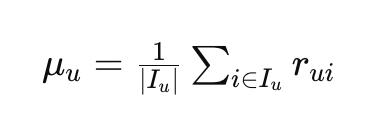

> Where \
uu = Mean rating for user u computed using her specified ratings;\
Iu = Set of item indices for which ratings have been specified by user u;\
ruk = Rating of user u for item k.

 In plain words, explain the meaning of Iu ∩ Iv. Can Iu ∩ Iv = ∅? (Hint: Rating matrix R is sparse)

> Iu ∩ Iv represents the intersection of the sets Iu and Iv which means the intersection of the movies rated by user u and user v. This intersection represents the set of movies rated by both the users u and v.
Yes, this set i.e the intersection can be 0 if both the users, u and v, have never rated the same movie i.e there are no common movies rated by user u and user v.


# **Question 3**

QUESTION 3: Understanding the Prediction function: Can you explain the reason behind mean-centering the raw ratings (rvj − μv) in the prediction function? (Hint: Consider users who either rate all items highly or rate all items poorly and the impact of these users on the prediction function.)

> Mean centering the raw ratings is important to normalize the ratings relative to the user baseline. This normalization helps in comparing ratings across different users who may have different rating scales or tendencies. It ensures that the prediction is not biased by users who generally rate items higher or lower than others. It also takes into account the individual bias of the users. Mean-centering allows the collaborative filtering algorithm to focus on the relative differences in ratings rather than absolute values. In sparse datasets where users have rated only a small subset of items, mean-centering helps in making predictions even when there is limited overlap between users or items. Overall, mean-centering the raw ratings in the prediction function improves the robustness, accuracy, and generalization ability of collaborative filtering algorithms by accounting for user biases, normalizing ratings, and reducing the impact of sparsity in the dataset.


# **Question 4**

In [4]:
# Defining the reader for surprise library
reader = Reader()

# Load the data into Surprise Dataset
ratings_data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

In [5]:
#Setting the value of k from 1 to 100 in steps of 2
k = np.arange(2,102,2)

In [8]:
#Calculating the rsme and mae using cv=10
rmse = []
mae = []
for i in k:
  res = cross_validate(KNNWithMeans(k=i,sim_options={'name':'pearson'}), measures=['rmse','mae'],data = ratings_data,cv=10,n_jobs=-1)
  rmse.append(np.mean(res['test_rmse']))
  mae.append(np.mean(res['test_mae']))

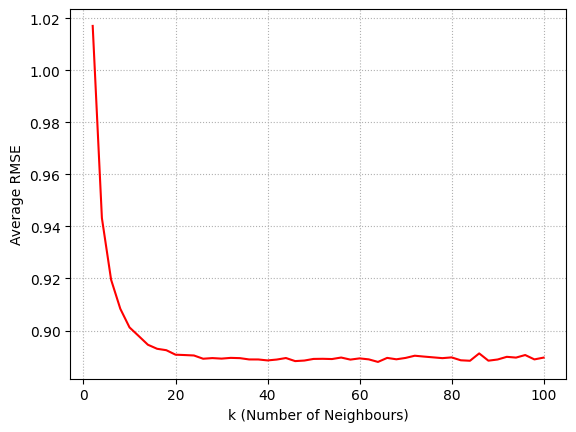

In [ ]:
# Plotting the graph of average rmse ahainst the value of k i.e the number of neighbours
plt.plot(k,rmse,linestyle='-',color='r')
plt.grid(linestyle=':')
plt.ylabel('Average RMSE')
plt.xlabel('k (Number of Neighbours)')
plt.show()

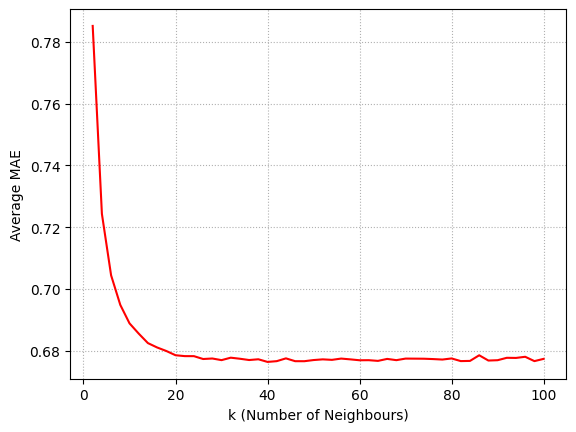

In [ ]:
# Plotting the graph of average mae ahainst the value of k i.e the number of neighbours
plt.plot(k,mae,linestyle='-',color='r')
plt.grid(linestyle=':')
plt.ylabel('Average MAE')
plt.xlabel('k (Number of Neighbours)')
plt.show()

QUESTION 4: Design a k-NN collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross validation. Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis) and average MAE (Y-axis) against k (X-axis).

> The two graphs above show the kNN Collaborative filter. We can see that the value is monotonically decreasing until a point after which we do not see any significant decrease in the average values. This trend is observed for both the graphs.


# **Question 5**

In [9]:
#Finding the minimum rmse and mae values and the corresponding k values
rmse_min_value = min(rmse)
rmse_min_index = rmse.index(rmse_min_value)
k_val_rmse = k[rmse_min_index]
mae_min_value = min(mae)
mae_min_index = mae.index(mae_min_value)
k_val_mae = k[mae_min_index]
print('Min value of RMSE: ',rmse_min_value)
print('K Value corresponding to min value of RMSE: ',k_val_rmse)
print('Min value of MAE: ',mae_min_value)
print('K Value corresponding to min value of MAE: ',k_val_mae)

Min value of RMSE:  0.8883963716107726
K Value corresponding to min value of RMSE:  42
Min value of MAE:  0.6761575337414852
K Value corresponding to min value of MAE:  42


QUESTION 5: Use the plot from question 4, to find a ’minimum k’. Note: The term ’minimum k’ in this context means that increasing k above the minimum value would not result in a significant decrease in average RMSE or average MAE. If you get the plot correct, then ’minimum k’ would correspond to the k value for which average RMSE and average MAE converge to a steady-state value. Please report the steady state values of average RMSE and average MAE.

> We find the values as below:\
Min value of RMSE:  0.8883963716107726\
K Value corresponding to min value of RMSE:  42\
Min value of MAE:  0.6761575337414852\
K Value corresponding to min value of MAE:  42

# **Question 6**

In [58]:
# Popular movie trimming
def popular_movie_trimming(df):
    # Count ratings per movie
    movie_ratings_count = df.groupby('movieId').size().reset_index(name='ratings_count')
    # Filter movies with more than 2 ratings
    popular_movies = movie_ratings_count[movie_ratings_count['ratings_count'] > 2]
    # Filter dataset based on popular movies
    df_popular = df[df['movieId'].isin(popular_movies['movieId'])]
    return df_popular

# Unpopular movie trimming
def unpopular_movie_trimming(df):
    # Count ratings per movie
    movie_ratings_count = df.groupby('movieId').size().reset_index(name='ratings_count')
    # Filter movies with 2 or fewer ratings
    unpopular_movies = movie_ratings_count[movie_ratings_count['ratings_count'] <= 2]
    # Filter dataset based on unpopular movies
    df_unpopular = df[df['movieId'].isin(unpopular_movies['movieId'])]
    return df_unpopular

# High variance movie trimming
def high_variance_movie_trimming(df):
    # Calculate variance and count of ratings per movie
    movie_stats = df.groupby('movieId')['rating'].agg(['var', 'count']).reset_index()
    # Filter movies with variance >= 2 and at least 5 ratings
    high_variance_movies = movie_stats[(movie_stats['var'] >= 2) & (movie_stats['count'] >= 5)]
    # Filter dataset based on high variance movies
    df_high_variance = df[df['movieId'].isin(high_variance_movies['movieId'])]
    return df_high_variance

# Trim the dataset based on each trimming option
df_popular = popular_movie_trimming(ratings)
df_unpopular = unpopular_movie_trimming(ratings)
df_high_variance = high_variance_movie_trimming(ratings)

In [ ]:
df_popular.head()

,userId,movieId,rating
0,496,112852,3.0
1,391,1947,4.0
2,387,1562,1.5
3,474,2716,4.5
4,483,88125,4.5


In [ ]:
#Using cross validate on popular data
avg_rmse_values_popular=[]
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in k:
    algo = KNNWithMeans(k=i, sim_options={'user_based': True, 'name':'pearson'})
    results = cross_validate(algo, data_popular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_popular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_values_popular.append(avg_rmse_popular)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

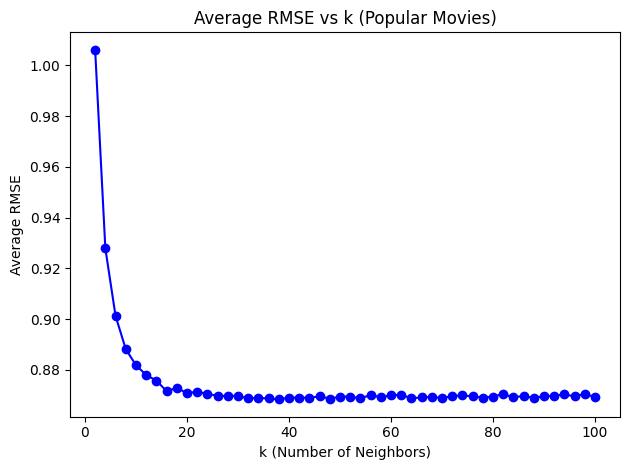

Minimum Average RMSE for Popular Movies: 0.8684798204535076 for k = 38


In [ ]:
#Plotting the graph for Popular condition using cross validate
plt.plot(k, avg_rmse_values_popular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Popular Movies)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_popular = min(avg_rmse_values_popular)
min_avg_ind_popular = avg_rmse_values_popular.index(min_avg_rmse_popular)
min_k_val_cv_popular = k[min_avg_ind_popular]
print(f"Minimum Average RMSE for Popular Movies: {min_avg_rmse_popular} for k = {min_k_val_cv_popular}")

In [ ]:
#Using KFold on popular data
rmse_pop = []
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in k:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_popular):
        res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_pop.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

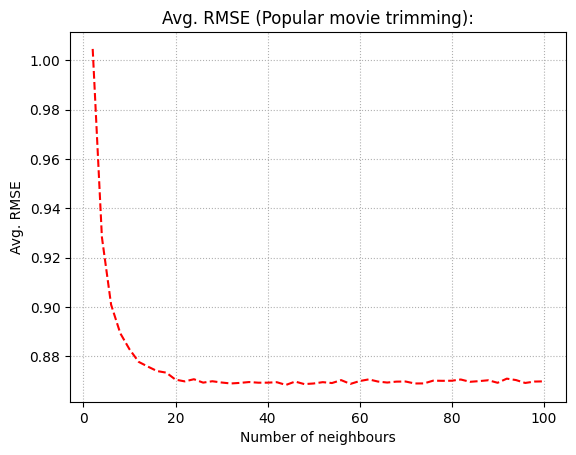

Minimum Average RMSE for Popular Movies: 0.8684169363140496 for k = 44


In [ ]:
#Plotting the graph for Popular condition using KFold
plt.plot(k,rmse_pop,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Popular movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_pop = min(rmse_pop)
min_avg_ind_pop = rmse_pop.index(min_avg_rmse_pop)
min_k_val_pop = k[min_avg_ind_pop]
print(f"Minimum Average RMSE for Popular Movies: {min_avg_rmse_pop} for k = {min_k_val_pop}")

In [ ]:
#Using cross validate on unpopular data
avg_rmse_values_unpopular=[]
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in k:
    algo = KNNWithMeans(k=i, sim_options={'user_based': True, 'name':'pearson'})
    results = cross_validate(algo, data_unpopular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_unpopular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_values_unpopular.append(avg_rmse_unpopular)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

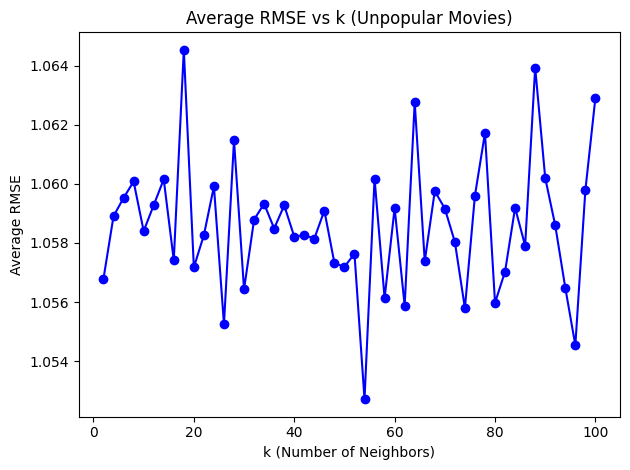

Minimum Average RMSE for Unpopular Movies: 1.0527101848059413 for k = 54


In [ ]:
#Plotting the graph for Unpopular condition using cross validate
plt.plot(k, avg_rmse_values_unpopular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Unpopular Movies)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_unpopular = min(avg_rmse_values_unpopular)
min_avg_ind_unpopular = avg_rmse_values_unpopular.index(min_avg_rmse_unpopular)
min_k_val_cv_unpopular = k[min_avg_ind_unpopular]
print(f"Minimum Average RMSE for Unpopular Movies: {min_avg_rmse_unpopular} for k = {min_k_val_cv_unpopular}")

In [ ]:
#Using KFold on unpopular data
rmse_unpopular = []
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in k:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_unpopular):
        res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_unpopular.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

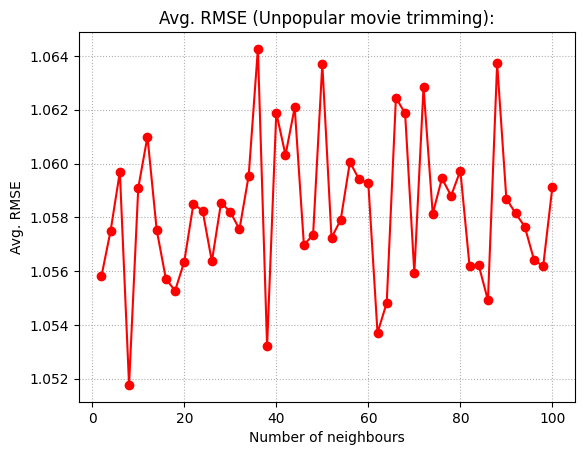

Minimum Average RMSE for Unpopular Movies: 1.051767399467695 for k = 8


In [ ]:
#Plotting the graph for Unpopular condition using KFold
plt.plot(k,rmse_unpopular, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Unpopular movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_unpop = min(rmse_unpopular)
min_avg_ind_unpop = rmse_unpopular.index(min_avg_rmse_unpop)
min_k_val_unpop = k[min_avg_ind_unpop]
print(f"Minimum Average RMSE for Unpopular Movies: {min_avg_rmse_unpop} for k = {min_k_val_unpop}")

In [19]:
#Using cross validate on high variance data
avg_rmse_values_high_variance=[]
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in k:
    algo = KNNWithMeans(k=i, sim_options={'user_based': True, 'name':'pearson'})
    results = cross_validate(algo, data_high_variance, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_high_variance = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_values_high_variance.append(avg_rmse_high_variance)

Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.
Computing the pearson similarity matrix...
Done computing similarity matrix.

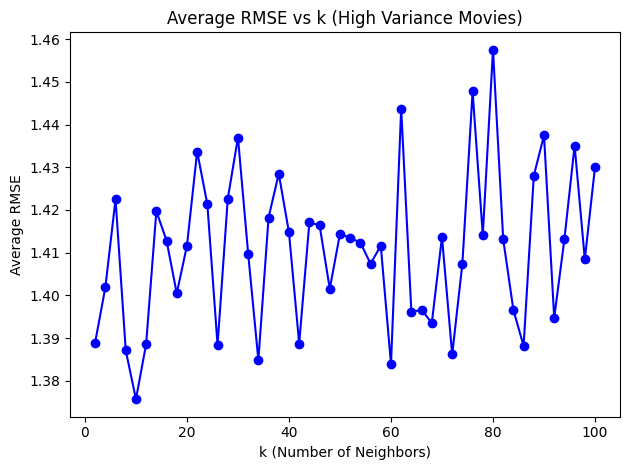

Minimum Average RMSE for High Variance Movies: 1.37570326107562 for k = 10


In [20]:
#Plotting the graph for high variance condition using cross validate
plt.plot(k, avg_rmse_values_high_variance, marker='o', color='blue')
plt.title(f'Average RMSE vs k (High Variance Movies)')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_high_variance = min(avg_rmse_values_high_variance)
min_avg_ind_high_variance = avg_rmse_values_high_variance.index(min_avg_rmse_high_variance)
min_k_val_cv_high_variance = k[min_avg_ind_high_variance]
print(f"Minimum Average RMSE for High Variance Movies: {min_avg_rmse_high_variance} for k = {min_k_val_cv_high_variance}")

In [ ]:
#Using KFold on high variance data
rmse_high_variance = []
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in k:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_high_variance):
        res = KNNWithMeans(k=item,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_high_variance.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

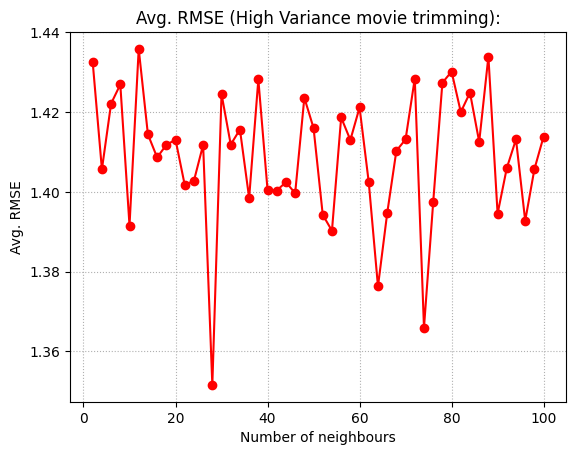

Minimum Average RMSE for High Variance Movies: 1.3515786593368913 for k = 28


In [ ]:
#Plotting the graph for Unpopular condition using KFold
plt.plot(k,rmse_high_variance, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (High Variance movie trimming):')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_hv = min(rmse_high_variance)
min_avg_ind_hv = rmse_high_variance.index(min_avg_rmse_hv)
min_k_val_hv = k[min_avg_ind_hv]
print(f"Minimum Average RMSE for High Variance Movies: {min_avg_rmse_hv} for k = {min_k_val_hv}")

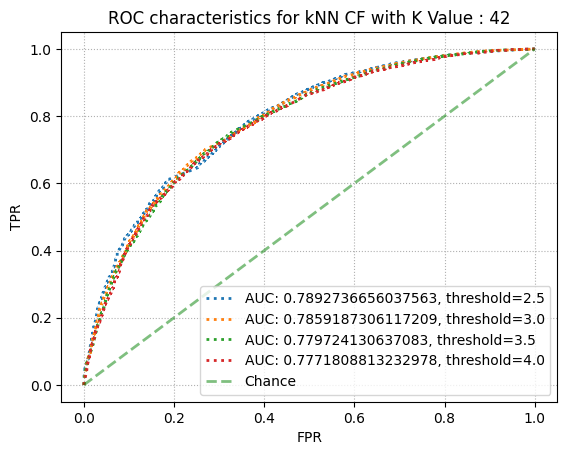

In [19]:
#Plotting ROC Curve for untrimmed data
k = k_val_rmse
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(ratings_data, test_size=0.1)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for kNN CF with K Value : ' + str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

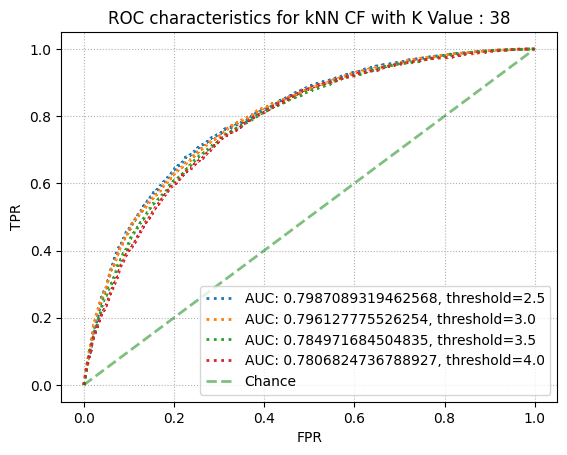

In [ ]:
#Plotting ROC Curve for popular data
k = min_k_val_cv_popular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_popular, test_size=0.1)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for kNN CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

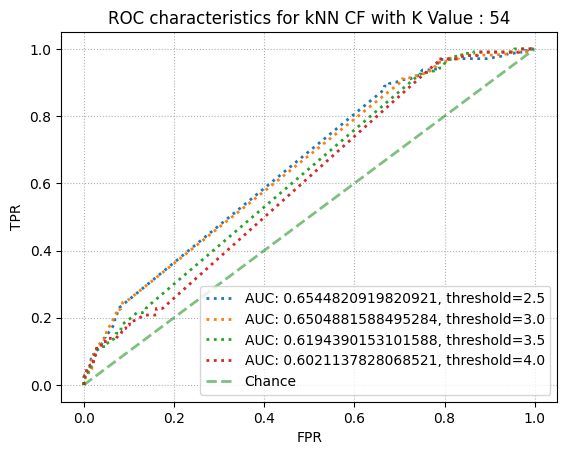

In [ ]:
#Plotting ROC Curve for unpopular data
k = min_k_val_cv_unpopular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_unpopular, test_size=0.1)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for kNN CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

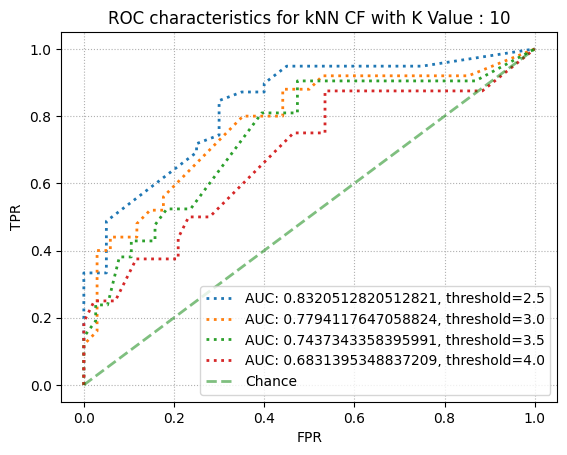

In [21]:
#Plotting ROC Curve for high variance data
k = min_k_val_cv_high_variance
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_high_variance, test_size=0.1)
res  = KNNWithMeans(k=k,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for kNN CF with K Value : ' + str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

QUESTION 6: Within EACH of the 3 trimmed subsets in the dataset, design (train and validate):
A k-NN collaborative filter on the ratings of the movies (i.e Popular, Unpopular or High-Variance) and evaluate each of the three models’ performance using 10-fold cross validation:
Sweep k (number of neighbors) from 2 to 100 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds. Plot average RMSE (Y-axis) against k (X-axis). Also, report the minimum average RMSE.

>Popular Data\
Using cross validate:\
See the graph above\
Minimum Average RMSE for Popular Movies: 0.8684798204535076 for k = 38\
Using KFold:\
See the graph above\
Minimum Average RMSE for Popular Movies: 0.8684169363140496 for k = 44

>Unpopular Data\
Using cross validate:\
See the graph above\
Minimum Average RMSE for Unpopular Movies: 1.0527101848059413 for k = 54\
Using KFold:\
See the graph above\
Minimum Average RMSE for Unpopular Movies: 1.051767399467695 for k = 8

>High Variance Data\
Using cross validate:\
See the graph above\
Minimum Average RMSE for High Variance Movies: 1.3689870049936965 for k = 64\
Using KFold:\
See the graph above\
Minimum Average RMSE for High Variance Movies: 1.3515786593368913 for k = 28

Plot the ROC curves for the k-NN collaborative filters for threshold values [2.5, 3, 3.5, 4]. These thresholds are applied only on the ground truth labels in held-out validation set. For each of the plots, also report the area under the curve (AUC) value. You should have 4 × 4 plots in this section (4 trimming options – including no trimming times 4 thresholds) - all thresholds can be condensed into one plot per trimming option yielding only 4 plots.

> See the ROC Curves above

# **Question 7**

QUESTION 7: Understanding the NMF cost function: Is the optimization problem given by equation 5 convex? Consider the optimization problem given by equation 5. For U fixed, formulate it as a least-squares problem.

> No, the optimization problem is not convex. Both matrices U and V are unknown variables at the same time. If we fix one of the two variables and then try and solve for the other variable, then the given optimization problem can be formulated to a least squares problem which is a convex problem. Therefore, the optimization problem is not jointly convex for both U and V due to the existence of multiple local minima in the objective function gradient plane. If we fix U and solve for matrix V, the least squares problem will be:

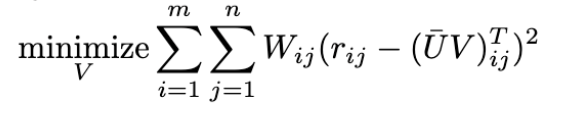






# **Question 8**

In [10]:
#For untrimmed data
# Define the range of latent factors (k) from 2 to 50 in step sizes of 2
latent_factors_number = range(2, 52, 2)

# Lists to store average RMSE and MAE values for each k
avg_rmse_values_NMF_not_trimmed = []
avg_mae_values_NMF_not_trimmed = []

# Iterate through different values of latent factors (k)
for k in latent_factors_number:
    algo = NMF(n_factors=k, random_state=42)
    results = cross_validate(algo, ratings_data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_rmse_values_NMF_not_trimmed.append(np.mean(results['test_rmse']))
    avg_mae_values_NMF_not_trimmed.append(np.mean(results['test_mae']))

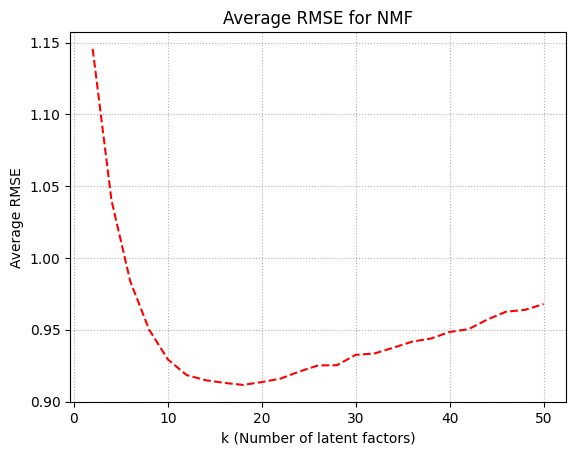

In [7]:
#Plotting the graph for Average RMSE against k i.e number of latent factors
plt.plot(latent_factors_number,avg_rmse_values_NMF_not_trimmed,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Average RMSE for NMF')
plt.ylabel('Average RMSE')
plt.xlabel('k (Number of latent factors)')
plt.show()

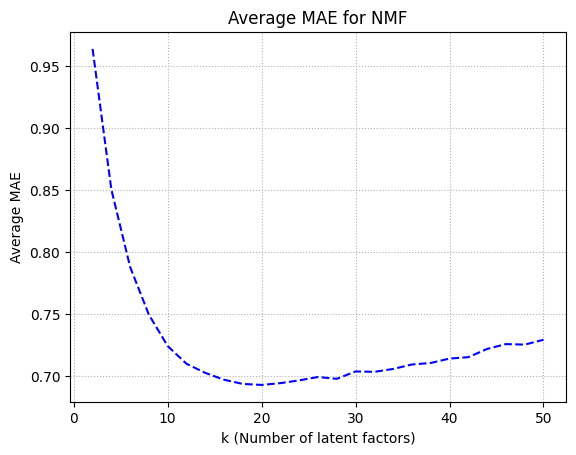

In [8]:
#Plotting the graph for Average MAE against k i.e number of latent factors
plt.plot(latent_factors_number,avg_mae_values_NMF_not_trimmed,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average MAE for NMF')
plt.ylabel('Average MAE')
plt.xlabel('k (Number of latent factors)')
plt.show()

In [11]:
#Finding the minimum value of RMSE and MAE and the corresponding k values
rmse_nmf_min_value = min(avg_rmse_values_NMF_not_trimmed)
rmse_nmf_min_index = avg_rmse_values_NMF_not_trimmed.index(rmse_nmf_min_value)
k_val_rmse_nmf = latent_factors_number[rmse_nmf_min_index]
mae_nmf_min_value = min(avg_mae_values_NMF_not_trimmed)
mae_nmf_min_index = avg_mae_values_NMF_not_trimmed.index(mae_nmf_min_value)
k_val_mae_nmf = latent_factors_number[mae_nmf_min_index]
print('Min value of RMSE: ',rmse_nmf_min_value)
print('K Value for NMF corresponding to min value of RMSE: ',k_val_rmse_nmf)
print('Min value of MAE: ',mae_nmf_min_value)
print('K Value for NMF corresponding to min value of MAE: ',k_val_mae_nmf)

Min value of RMSE:  0.9143005748405425
K Value for NMF corresponding to min value of RMSE:  16
Min value of MAE:  0.6942119087641884
K Value for NMF corresponding to min value of MAE:  24


In [ ]:
#For popular data using cross validate
avg_rmse_nmf_values_popular=[]
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = NMF(n_factors=i, random_state=42)
    results = cross_validate(algo, data_popular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_nmf_popular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_nmf_values_popular.append(avg_rmse_nmf_popular)

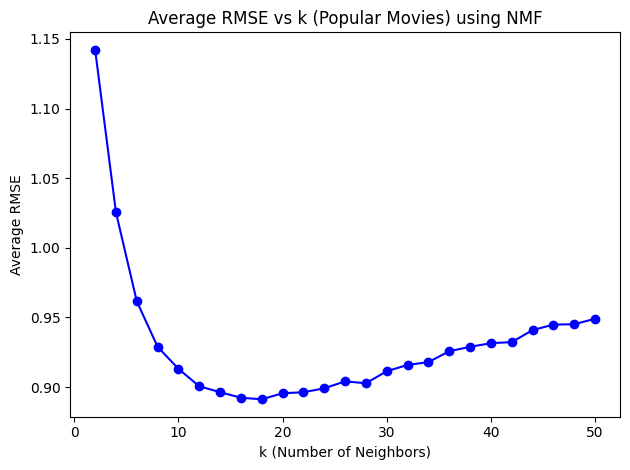

Minimum Average RMSE for Popular Movies using NMF: 0.8912869916751903 for k = 18


In [ ]:
#Plotting the graph for Popular data using cross validate
plt.plot(latent_factors_number, avg_rmse_nmf_values_popular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Popular Movies) using NMF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_popular = min(avg_rmse_nmf_values_popular)
min_avg_ind_nmf_popular = avg_rmse_nmf_values_popular.index(min_avg_rmse_nmf_popular)
min_k_val_cv_nmf_popular = latent_factors_number[min_avg_ind_nmf_popular]
print(f"Minimum Average RMSE for Popular Movies using NMF: {min_avg_rmse_nmf_popular} for k = {min_k_val_cv_nmf_popular}")

In [ ]:
#Using KFold on popular data
rmse_nmf_pop = []
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_popular):
        res = NMF(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_nmf_pop.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

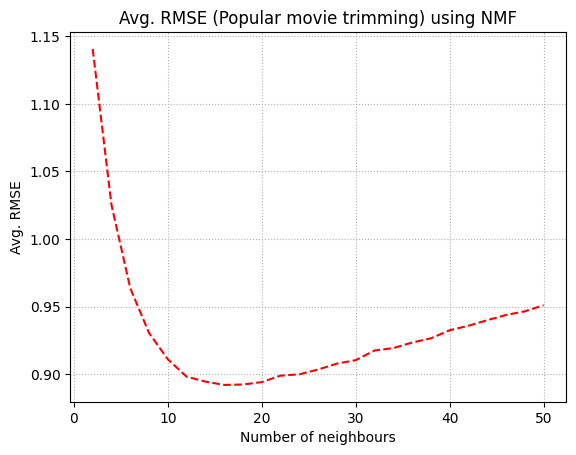

Minimum Average RMSE for Popular Movies using NMF: 0.892189371583061 for k = 16


In [ ]:
#Plotting the graph for Popular condition using KFold
plt.plot(latent_factors_number,rmse_nmf_pop,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Popular movie trimming) using NMF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_pop = min(rmse_nmf_pop)
min_avg_ind_nmf_pop = rmse_nmf_pop.index(min_avg_rmse_nmf_pop)
min_k_val_nmf_pop = latent_factors_number[min_avg_ind_nmf_pop]
print(f"Minimum Average RMSE for Popular Movies using NMF: {min_avg_rmse_nmf_pop} for k = {min_k_val_nmf_pop}")

In [ ]:
#For unpopular data using cross validate
avg_rmse_nmf_values_unpopular=[]
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = NMF(n_factors=i, random_state=42)
    results = cross_validate(algo, data_unpopular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_unpopular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_nmf_values_unpopular.append(avg_rmse_unpopular)

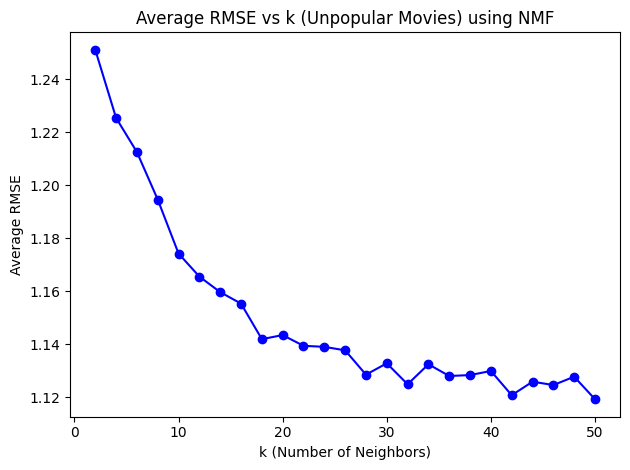

Minimum Average RMSE for Unpopular Movies using NMF: 1.1191761795398452 for k = 50


In [ ]:
#Plotting the graph for unopular data using cross validate
plt.plot(latent_factors_number, avg_rmse_nmf_values_unpopular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Unpopular Movies) using NMF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_unpopular = min(avg_rmse_nmf_values_unpopular)
min_avg_ind_nmf_unpopular = avg_rmse_nmf_values_unpopular.index(min_avg_rmse_nmf_unpopular)
min_k_val_cv_nmf_unpopular = latent_factors_number[min_avg_ind_nmf_unpopular]
print(f"Minimum Average RMSE for Unpopular Movies using NMF: {min_avg_rmse_nmf_unpopular} for k = {min_k_val_cv_nmf_unpopular}")

In [ ]:
#Using KFold on unpopular data
rmse_nmf_unpopular = []
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_unpopular):
        res = NMF(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_nmf_unpopular.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

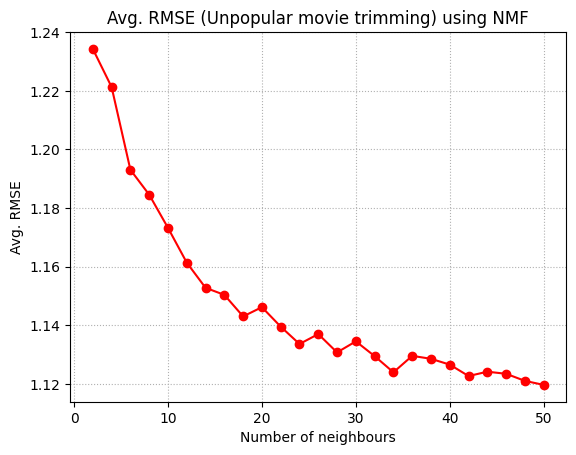

Minimum Average RMSE for Unpopular Movies using NMF: 1.1196456867107254 for k = 50


In [ ]:
#Plotting the graph for unopular condition using KFold
plt.plot(latent_factors_number,rmse_nmf_unpopular, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Unpopular movie trimming) using NMF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_unpop = min(rmse_nmf_unpopular)
min_avg_ind_nmf_unpop = rmse_nmf_unpopular.index(min_avg_rmse_nmf_unpop)
min_k_val_nmf_unpop = latent_factors_number[min_avg_ind_nmf_unpop]
print(f"Minimum Average RMSE for Unpopular Movies using NMF: {min_avg_rmse_nmf_unpop} for k = {min_k_val_nmf_unpop}")

In [ ]:
#For high variance data using cross validate
avg_rmse_nmf_values_high_variance=[]
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = NMF(n_factors=i, random_state=42)
    results = cross_validate(algo, data_high_variance, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_high_variance = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_nmf_values_high_variance.append(avg_rmse_high_variance)

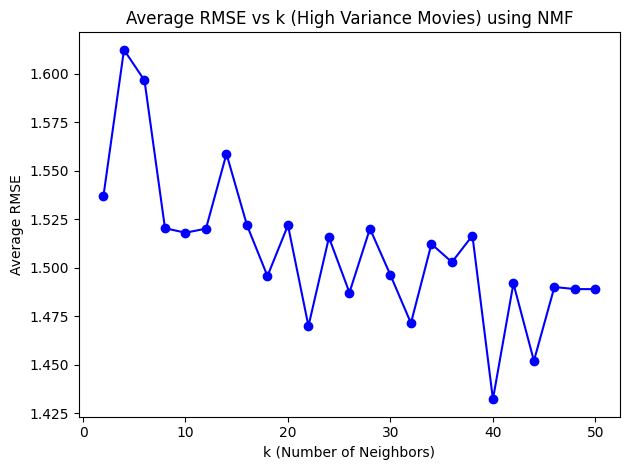

Minimum Average RMSE for High Variance Movies using NMF: 1.4322523568216146 for k = 40


In [ ]:
#Plotting the graph for high variance using cross validate
plt.plot(latent_factors_number, avg_rmse_nmf_values_high_variance, marker='o', color='blue')
plt.title(f'Average RMSE vs k (High Variance Movies) using NMF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_high_variance = min(avg_rmse_nmf_values_high_variance)
min_avg_ind_nmf_high_variance = avg_rmse_nmf_values_high_variance.index(min_avg_rmse_nmf_high_variance)
min_k_val_cv_nmf_high_variance = latent_factors_number[min_avg_ind_nmf_high_variance]
print(f"Minimum Average RMSE for High Variance Movies using NMF: {min_avg_rmse_nmf_high_variance} for k = {min_k_val_cv_nmf_high_variance}")

In [ ]:
#Using KFold on high variance data
rmse_nmf_high_variance = []
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_high_variance):
        res = NMF(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_nmf_high_variance.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

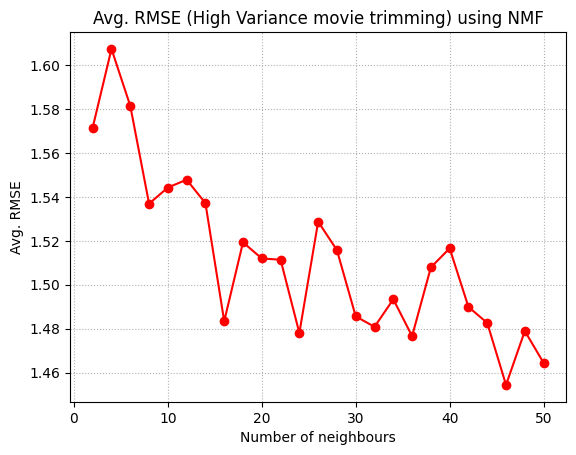

Minimum Average RMSE for High Variance Movies using NMF: 1.454408430825764 for k = 46


In [ ]:
#Plotting the graph for high variance condition using KFold
plt.plot(latent_factors_number,rmse_nmf_high_variance, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (High Variance movie trimming) using NMF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_nmf_hv = min(rmse_nmf_high_variance)
min_avg_ind_nmf_hv = rmse_nmf_high_variance.index(min_avg_rmse_nmf_hv)
min_k_val_nmf_hv = latent_factors_number[min_avg_ind_nmf_hv]
print(f"Minimum Average RMSE for High Variance Movies using NMF: {min_avg_rmse_nmf_hv} for k = {min_k_val_nmf_hv}")

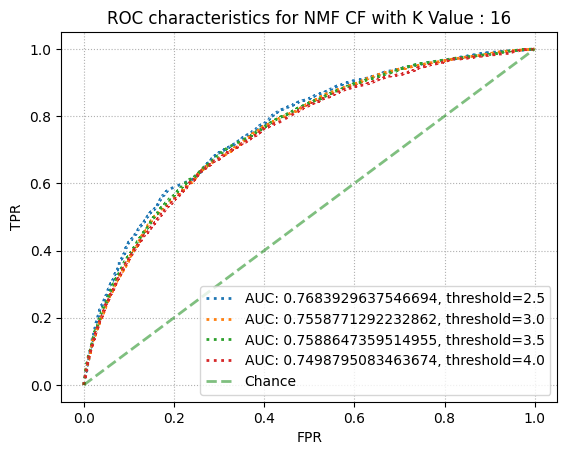

In [20]:
#Plotting ROC Curve for untrimmed data
k = k_val_rmse_nmf
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(ratings_data, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

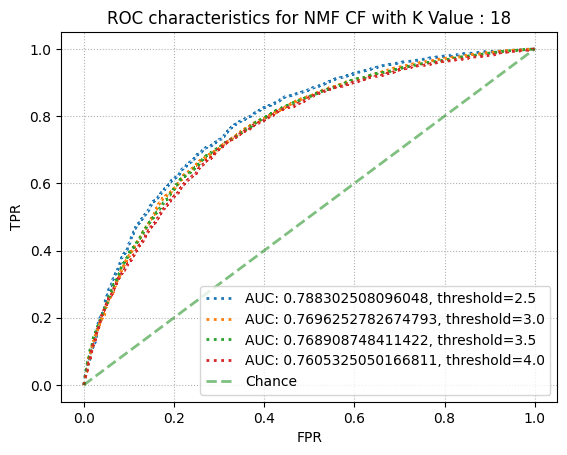

In [ ]:
#Plotting ROC Curve for popular data
k = min_k_val_cv_nmf_popular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_popular, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

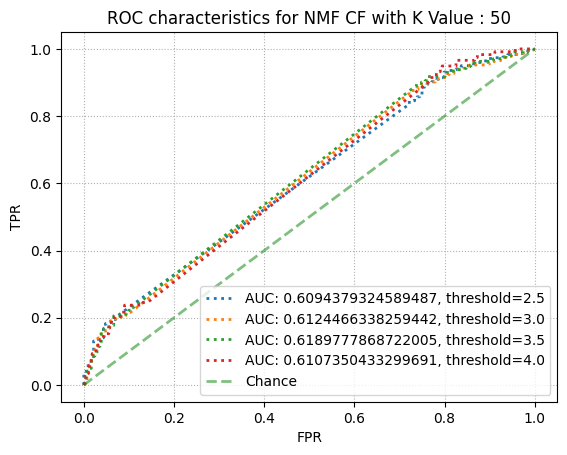

In [ ]:
#Plotting ROC Curve for unpopular data
k = min_k_val_cv_nmf_unpopular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_unpopular, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

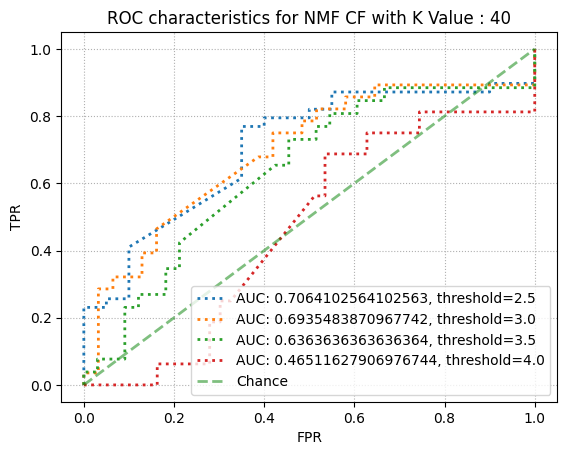

In [ ]:
#Plotting ROC Curve for high variance data
k = min_k_val_cv_nmf_high_variance
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_high_variance, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for NMF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

QUESTION 8:

Design a NMF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate its performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. If NMF takes too long, you can increase the step size. Increasing it too much will result in poorer granularity in your results. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y- axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

>Refer to the graphs above. We can see that the error first decreases with an increase in k (Number of latent factors). But, after a point, it starts increasing linearly. This increasing value of k does not help significantly with the performance. This is because increasing k leads to an increase in the dimension and the rating matrix becomes noisy.

Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

> Min value of RMSE:  0.9143005748405425\
K Value for NMF corresponding to min value of RMSE:  16\
Min value of MAE:  0.6942119087641884\
K Value for NMF corresponding to min value of MAE:  24\
There are 19 genres of movies in the dataset. The optimal value of k we have obtained is very close to this  number.

Performance on trimmed dataset subsets: For each of Popular, Unpopular and High- Variance subsets -
Design a NMF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

> Popular Data: \
Refer to the graphs above\
Using cross validate:\
Minimum Average RMSE for Popular Movies using NMF: 0.8912869916751903 for k = 18\
Using KFold:\
Minimum Average RMSE for Popular Movies using NMF: 0.892189371583061 for k = 16

> Unpopular Data: \
Refer to the graphs above\
Using cross validate:\
Minimum Average RMSE for Unpopular Movies using NMF: 1.1191761795398452 for k = 50\
Using KFold:\
Minimum Average RMSE for Unpopular Movies using NMF: 1.1196456867107254 for k = 50

> High Variance Data: \
Refer to the graphs above\
Using cross validate:\
Minimum Average RMSE for High Variance Movies using NMF: 1.4322523568216146 for k = 40\
Using KFold:\
Minimum Average RMSE for High Variance Movies using NMF: 1.454408430825764 for k = 46

 Plot the ROC curves for the NMF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

> Refer to the ROC Curves above


# **Question 9**

In [ ]:
#Loading the dataset and getting th evalues of U and V
movies = pd.read_csv('gdrive/My Drive/Winter Quarter 2024/219 - Large Scale Data Mining/Project 3/Synthetic_Movie_Lens/movies.csv',usecols=['movieId','title','genres'])
trainset, testset = train_test_split(ratings_data, test_size=0.1)
nmf = NMF(n_factors=20,verbose=False)
nmf.fit(trainset).test(testset)
U = nmf.pu
V = nmf.qi

In [ ]:
print(len(V))

9389


In [ ]:
#Printing the top 10 movies
for item in range(0,20):
    print('----------------------- Value of k: ',item, ' -----------------------')
    selected_col = V[:,item]
    sorted_col = np.argsort(selected_col)[::-1]
    for i in sorted_col[0:10]:
        print(movies['genres'][i])

----------------------- Value of k:  0  -----------------------
Action|Adventure|Drama
Comedy|Drama|Romance
Sci-Fi|Thriller
Adventure|Drama|Romance
Action|Crime|Thriller
Comedy|Drama
Comedy|Drama
Comedy|Drama
Drama|Film-Noir|Thriller
Comedy|Drama|Fantasy
----------------------- Value of k:  1  -----------------------
Action|Drama|Sci-Fi|Thriller
Fantasy|Musical|Romance
Drama|Musical
Drama
Comedy|Drama|Fantasy|Mystery|Romance
Comedy|Romance
Comedy
Animation|Children
Drama
Comedy|Crime|Horror
----------------------- Value of k:  2  -----------------------
Comedy
Comedy|Drama
Comedy|Drama|Romance
Comedy|Crime
Action|Crime|Thriller
Crime|Drama
Drama
Comedy|Drama|Romance
Comedy|Drama|Romance|Western
Comedy|Romance
----------------------- Value of k:  3  -----------------------
Children|Fantasy|Musical
Comedy|War
Romance
Sci-Fi|Thriller
Comedy|Sci-Fi
Mystery|Thriller
Comedy
Drama|Fantasy
Drama|Musical|Romance
Adventure|Comedy|Romance
----------------------- Value of k:  4  ------------------

QUESTION 9: Interpreting the NMF model: Perform Non-negative matrix factorization on the ratings matrix R to obtain the factor matrices U and V , where U represents the user-latent factors interaction and V represents the movie-latent factors interaction (use k = 20). For each column of V , sort the movies in descending order and report the genres of the top 10 movies. Do the top 10 movies belong to a particular or a small collection of genre? Is there a connection between the latent factors and the movie genres?

>For k=20, we pick up the value of V, sort the movies in descending order and report the genres of the top 10 movies as above\
We can see that the latent factors are closely related to the movies. We can see that each group is strongly related to some genres whereas other groups are related to others. Thus we can conclude that the top 10 movies belong to a small set of genres for each group.

# **Question 10**

In [12]:
#For untrimmed data
# Define the range of latent factors (k) from 2 to 50 in step sizes of 2
latent_factors_number = range(2, 52, 2)

# Lists to store average RMSE and MAE values for each k
avg_rmse_values_MF_not_trimmed = []
avg_mae_values_MF_not_trimmed = []

# Iterate through different values of latent factors (k)
for k in latent_factors_number:
    algo = SVD(n_factors=k, random_state=42)
    results = cross_validate(algo, ratings_data, measures=['RMSE', 'MAE'], cv=10, verbose=False)
    avg_rmse_values_MF_not_trimmed.append(np.mean(results['test_rmse']))
    avg_mae_values_MF_not_trimmed.append(np.mean(results['test_mae']))

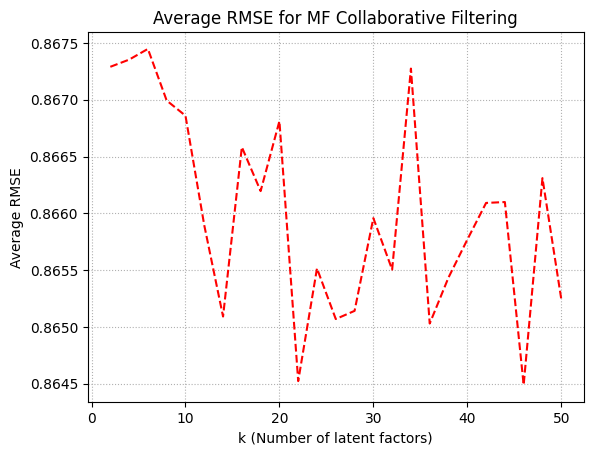

In [ ]:
#Plotting the graph of average RMSE and k i.e the number of latent factors
plt.plot(latent_factors_number,avg_rmse_values_MF_not_trimmed,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Average RMSE for MF Collaborative Filtering')
plt.ylabel('Average RMSE')
plt.xlabel('k (Number of latent factors)')
plt.show()

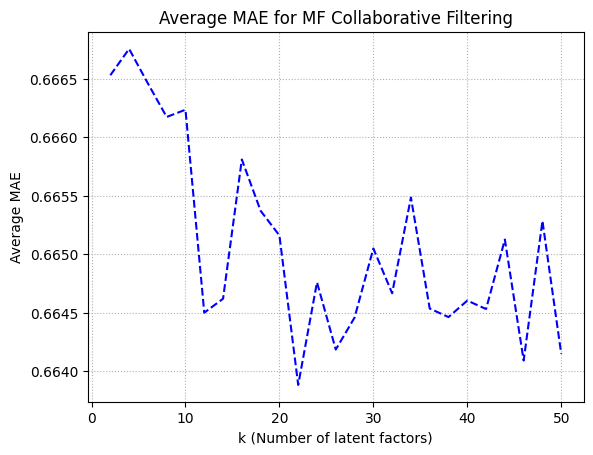

In [ ]:
#Plotting the graph of average MAE and k i.e the number of latent factors
plt.plot(latent_factors_number,avg_mae_values_MF_not_trimmed,linestyle='--',color='b')
plt.grid(linestyle=':')
plt.title('Average MAE for MF Collaborative Filtering')
plt.ylabel('Average MAE')
plt.xlabel('k (Number of latent factors)')
plt.show()

In [13]:
# Finding the minimum value of RMSE and MAE and the corresponding k values
rmse_mf_min_value = min(avg_rmse_values_MF_not_trimmed)
rmse_mf_min_index = avg_rmse_values_MF_not_trimmed.index(rmse_mf_min_value)
k_val_rmse_mf = latent_factors_number[rmse_mf_min_index]
mae_mf_min_value = min(avg_mae_values_MF_not_trimmed)
mae_mf_min_index = avg_mae_values_MF_not_trimmed.index(mae_mf_min_value)
k_val_mae_mf = latent_factors_number[mae_mf_min_index]
print('Min value of RMSE: ',rmse_mf_min_value)
print('K Value for MF corresponding to min value of RMSE: ',k_val_rmse_mf)
print('Min value of MAE: ',mae_mf_min_value)
print('K Value for MF corresponding to min value of MAE: ',k_val_mae_mf)

Min value of RMSE:  0.8638590129266989
K Value for MF corresponding to min value of RMSE:  28
Min value of MAE:  0.6629621308629217
K Value for MF corresponding to min value of MAE:  28


In [ ]:
#For popular data using cross validate
avg_rmse_mf_values_popular=[]
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = SVD(n_factors=i, random_state=42)
    results = cross_validate(algo, data_popular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_mf_popular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_mf_values_popular.append(avg_rmse_mf_popular)

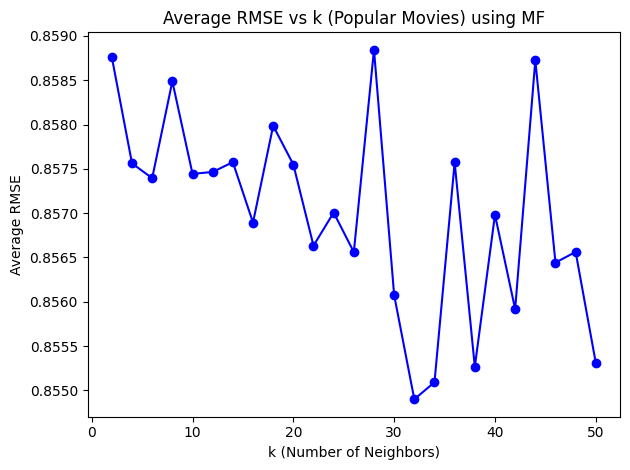

Minimum Average RMSE for Popular Movies using MF: 0.8548996644046705 for k = 32


In [ ]:
#Plotting the graph for Popular data using cross validate
plt.plot(latent_factors_number, avg_rmse_mf_values_popular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Popular Movies) using MF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_popular = min(avg_rmse_mf_values_popular)
min_avg_ind_mf_popular = avg_rmse_mf_values_popular.index(min_avg_rmse_mf_popular)
min_k_val_cv_mf_popular = latent_factors_number[min_avg_ind_mf_popular]
print(f"Minimum Average RMSE for Popular Movies using MF: {min_avg_rmse_mf_popular} for k = {min_k_val_cv_mf_popular}")

In [ ]:
#Using KFold on popular data
rmse_mf_pop = []
data_popular = Dataset.load_from_df(df_popular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_popular):
        res = SVD(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_mf_pop.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

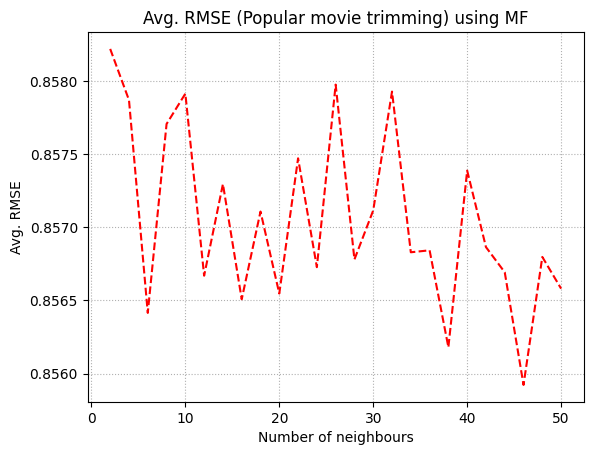

Minimum Average RMSE for Popular Movies using MF: 0.8559222450175007 for k = 46


In [ ]:
#Plotting the graph for Popular condition using KFold
plt.plot(latent_factors_number,rmse_mf_pop,linestyle='--',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Popular movie trimming) using MF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_pop = min(rmse_mf_pop)
min_avg_ind_mf_pop = rmse_mf_pop.index(min_avg_rmse_mf_pop)
min_k_val_mf_pop = latent_factors_number[min_avg_ind_mf_pop]
print(f"Minimum Average RMSE for Popular Movies using MF: {min_avg_rmse_mf_pop} for k = {min_k_val_mf_pop}")

In [ ]:
#For unpopular data using cross validate
avg_rmse_mf_values_unpopular=[]
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = SVD(n_factors=i, random_state=42)
    results = cross_validate(algo, data_unpopular, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_unpopular = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_mf_values_unpopular.append(avg_rmse_unpopular)

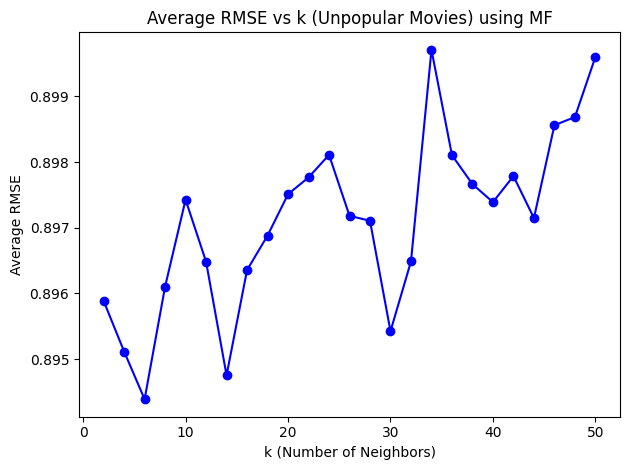

Minimum Average RMSE for Unpopular Movies using MF: 0.8943898168957268 for k = 6


In [ ]:
#Plotting the graph for unpopular data using cross validate
plt.plot(latent_factors_number, avg_rmse_mf_values_unpopular, marker='o', color='blue')
plt.title(f'Average RMSE vs k (Unpopular Movies) using MF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_unpopular = min(avg_rmse_mf_values_unpopular)
min_avg_ind_mf_unpopular = avg_rmse_mf_values_unpopular.index(min_avg_rmse_mf_unpopular)
min_k_val_cv_mf_unpopular = latent_factors_number[min_avg_ind_mf_unpopular]
print(f"Minimum Average RMSE for Unpopular Movies using MF: {min_avg_rmse_mf_unpopular} for k = {min_k_val_cv_mf_unpopular}")

In [ ]:
#Using KFold on unpopular data
rmse_mf_unpopular = []
data_unpopular = Dataset.load_from_df(df_unpopular[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_unpopular):
        res = SVD(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_mf_unpopular.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

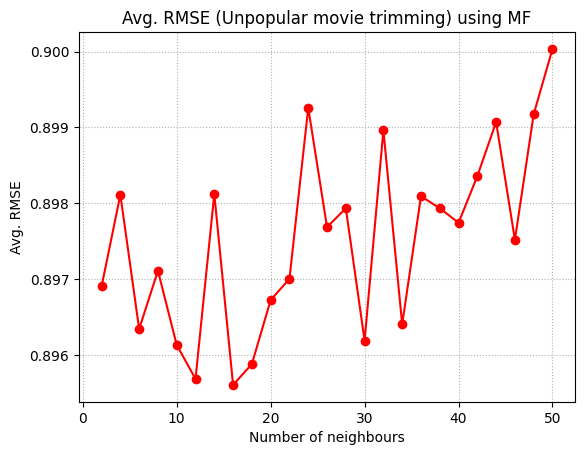

Minimum Average RMSE for Unpopular Movies using MF: 0.8956050581857941 for k = 16


In [ ]:
#Plotting the graph for Unpopular condition using KFold
plt.plot(latent_factors_number,rmse_mf_unpopular, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (Unpopular movie trimming) using MF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_unpop = min(rmse_mf_unpopular)
min_avg_ind_mf_unpop = rmse_mf_unpopular.index(min_avg_rmse_mf_unpop)
min_k_val_mf_unpop = latent_factors_number[min_avg_ind_mf_unpop]
print(f"Minimum Average RMSE for Unpopular Movies using MF: {min_avg_rmse_mf_unpop} for k = {min_k_val_mf_unpop}")

In [ ]:
#For high variance data using cross validate
avg_rmse_mf_values_high_variance=[]
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)

# Iterate through different values of k
for i in latent_factors_number:
    algo = SVD(n_factors=i, random_state=42)
    results = cross_validate(algo, data_high_variance, measures=['RMSE'], cv=10, verbose=False)
    avg_rmse_high_variance = sum(results['test_rmse']) / len(results['test_rmse'])
    avg_rmse_mf_values_high_variance.append(avg_rmse_high_variance)

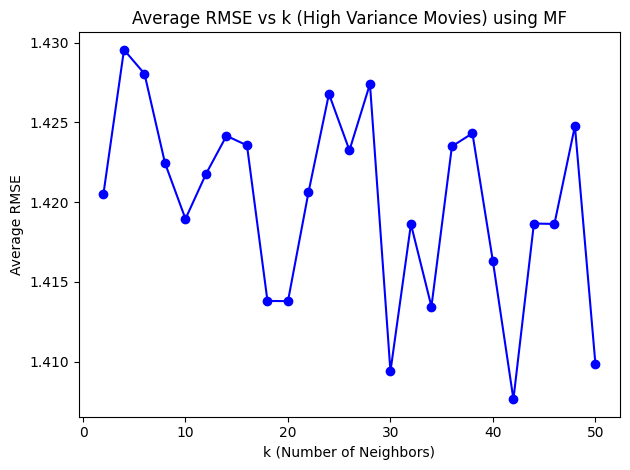

Minimum Average RMSE for High Variance Movies using MF: 1.4076443611129084 for k = 42


In [ ]:
#Plotting the graph for High Variance data using cross validate
plt.plot(latent_factors_number, avg_rmse_mf_values_high_variance, marker='o', color='blue')
plt.title(f'Average RMSE vs k (High Variance Movies) using MF')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Average RMSE')
plt.tight_layout()
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_high_variance = min(avg_rmse_mf_values_high_variance)
min_avg_ind_mf_high_variance = avg_rmse_mf_values_high_variance.index(min_avg_rmse_mf_high_variance)
min_k_val_cv_mf_high_variance = latent_factors_number[min_avg_ind_mf_high_variance]
print(f"Minimum Average RMSE for High Variance Movies using MF: {min_avg_rmse_mf_high_variance} for k = {min_k_val_cv_mf_high_variance}")

In [ ]:
#Using KFold on high variance data
rmse_mf_high_variance = []
data_high_variance = Dataset.load_from_df(df_high_variance[['userId', 'movieId', 'rating']], reader)
kf =  KFold(n_splits=10)
for item in latent_factors_number:
    local_rmse = []
    print('Testing for the following value of k: ',item)
    for trainset, testset in kf.split(data_high_variance):
        res = SVD(n_factors=item,verbose=False).fit(trainset).test(testset)
        local_rmse.append(accuracy.rmse(res,verbose=False))
    rmse_mf_high_variance.append(np.mean(local_rmse))

Testing for the following value of k:  2
Testing for the following value of k:  4
Testing for the following value of k:  6
Testing for the following value of k:  8
Testing for the following value of k:  10
Testing for the following value of k:  12
Testing for the following value of k:  14
Testing for the following value of k:  16
Testing for the following value of k:  18
Testing for the following value of k:  20
Testing for the following value of k:  22
Testing for the following value of k:  24
Testing for the following value of k:  26
Testing for the following value of k:  28
Testing for the following value of k:  30
Testing for the following value of k:  32
Testing for the following value of k:  34
Testing for the following value of k:  36
Testing for the following value of k:  38
Testing for the following value of k:  40
Testing for the following value of k:  42
Testing for the following value of k:  44
Testing for the following value of k:  46
Testing for the following value of k: 

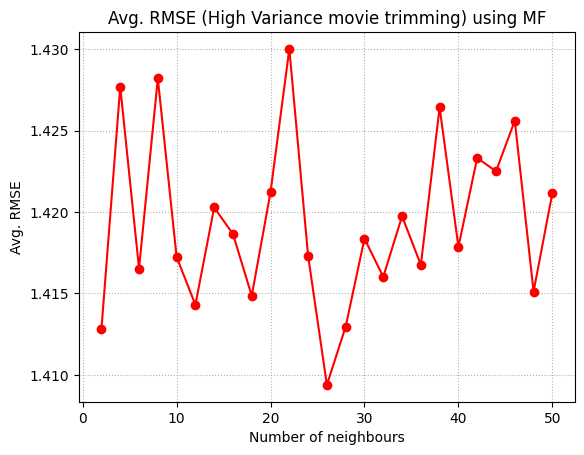

Minimum Average RMSE for High Variance Movies using MF: 1.4093797328685413 for k = 26


In [ ]:
#Plotting the graph for High Variance condition using KFold
plt.plot(latent_factors_number,rmse_mf_high_variance, marker='o',color='r')
plt.grid(linestyle=':')
plt.title('Avg. RMSE (High Variance movie trimming) using MF')
plt.ylabel('Avg. RMSE')
plt.xlabel('Number of neighbours')
plt.show()

# Report the minimum average RMSE
min_avg_rmse_mf_hv = min(rmse_mf_high_variance)
min_avg_ind_mf_hv = rmse_mf_high_variance.index(min_avg_rmse_mf_hv)
min_k_val_mf_hv = latent_factors_number[min_avg_ind_mf_hv]
print(f"Minimum Average RMSE for High Variance Movies using MF: {min_avg_rmse_mf_hv} for k = {min_k_val_mf_hv}")

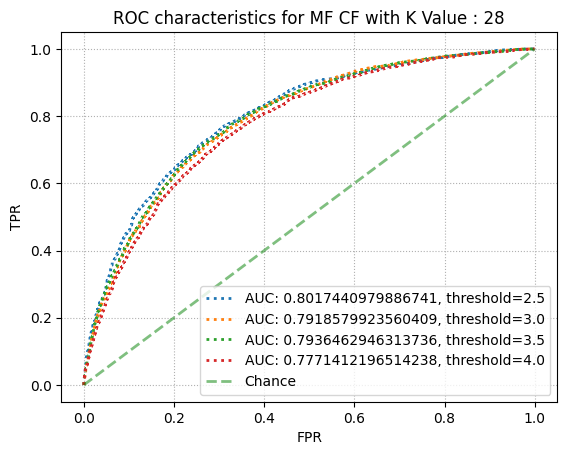

In [17]:
#Plotting ROC Curve for untrimmed data
k = k_val_rmse_mf
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(ratings_data, test_size=0.1)
res  = SVD(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for MF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

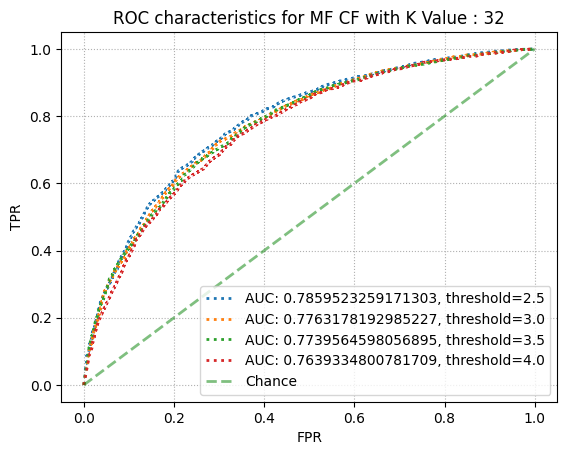

In [ ]:
#Plotting ROC Curve for popular data
k = min_k_val_cv_mf_popular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_popular, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for MF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

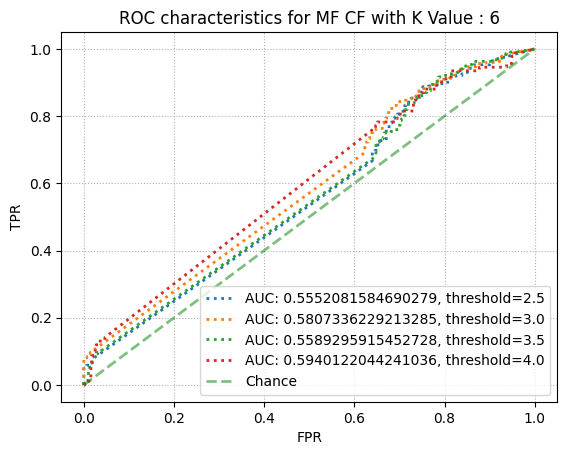

In [ ]:
#Plotting ROC Curve for unpopular data
k = min_k_val_cv_mf_unpopular
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_unpopular, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for MF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

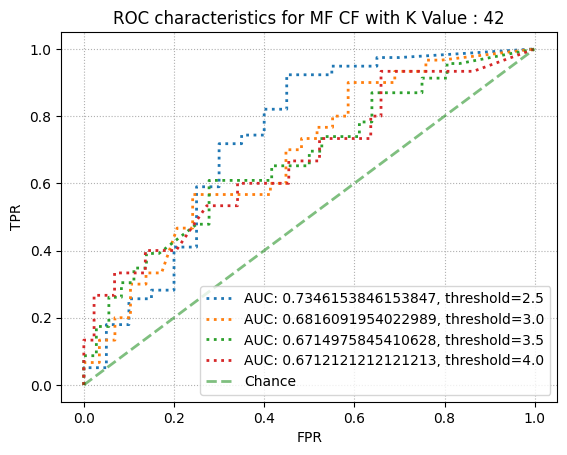

In [ ]:
#Plotting ROC Curve for high variance data
k = min_k_val_cv_mf_high_variance
thresholds = [2.5, 3.0, 3.5, 4.0]
trainset, testset = train_test_split(data_high_variance, test_size=0.1)
res  = NMF(n_factors=k,verbose=False).fit(trainset).test(testset)
fig, ax = plt.subplots()
for i in thresholds:
    thresholded_out = []
    for row in res:
        if row.r_ui > i:
            thresholded_out.append(1)
        else:
            thresholded_out.append(0)
    fpr, tpr, thresholds = roc_curve(thresholded_out, [row.est for row in res])
    ax.plot(fpr, tpr,lw=2,linestyle=':',label="AUC: "+str(auc(fpr,tpr))+', threshold='+str(i))
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='g', label='Chance', alpha=.5)
plt.legend(loc='best')
plt.grid(linestyle=':')
plt.title('ROC characteristics for MF CF with K Value : '+ str(k))
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.show()

QUESTION 10:

Designing the MF Collaborative Filter:
Design a MF-based collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross-validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE and average MAE obtained by averaging the RMSE and MAE across all 10 folds. Plot the average RMSE (Y-axis) against k (X-axis) and the average MAE (Y-axis) against k (X-axis). For solving this question, use the default value for the regularization parameter.

>Refer to the graphs above. Though the graph is erratic in nature, we can observe that the values are consistent for a tiny range of k.


Use the plot from the previous part to find the optimal number of latent factors. Optimal number of latent factors is the value of k that gives the minimum average RMSE or the minimum average MAE. Please report the minimum average RMSE and MAE. Is the optimal number of latent factors same as the number of movie genres?

>Min value of RMSE:  0.8638590129266989\
K Value for MF corresponding to min value of RMSE:  28\
Min value of MAE:  0.6629621308629217\
K Value for MF corresponding to min value of MAE:  28\
No, the optimal number of latents factors isn't the same. The value for MAE is pretty close to that of movie genres. This outperforms both kNN and NMF.

Performance on dataset subsets: For each of Popular, Unpopular and High-Variance subsets -
Design a MF collaborative filter for each trimmed subset and evaluate its performance using 10-fold cross validation. Sweep k (number of latent factors) from 2 to 50 in step sizes of 2, and for each k compute the average RMSE obtained by averaging the RMSE across all 10 folds.
Plot average RMSE (Y-axis) against k (X-axis); item Report the minimum average RMSE.

> Popular Data:\
Using cross validate:\
Minimum Average RMSE for Popular Movies using MF: 0.8548996644046705 for k = 32\
Using KFold:\
Minimum Average RMSE for Popular Movies using MF: 0.8559222450175007 for k = 46

> Unpopular Data:\
Using cross validate:\
Minimum Average RMSE for Unpopular Movies using MF: 0.8943898168957268 for k = 6\
Using KFold:\
Minimum Average RMSE for Unpopular Movies using MF: 0.8956050581857941 for k = 16

> High Variance Data:\
Using cross validate:\
Minimum Average RMSE for High Variance Movies using MF: 1.4076443611129084 for k = 42\
Using KFold:\
Minimum Average RMSE for High Variance Movies using MF: 1.4093797328685413 for k = 26

Plot the ROC curves for the MF-based collaborative filter and also report the area under the curve (AUC) value as done in Question 6.

>Refer to the ROC Curves above

# **Question 11**

In [44]:
from sklearn.model_selection import KFold

In [54]:
def predict(test,user_mean_ratings ):
    # Predict ratings using mean rating for each user
    predictions = []
    rmse_list = []

    for user_id, item_id, rating in test[['userId', 'movieId', 'rating']].values:
        if user_id in user_mean_ratings:
            predictions.append(user_mean_ratings[user_id])
        else:
            # If user is not in training set, use a default value or skip the prediction
            predictions.append(0)

    # Evaluate the predictions (e.g., calculate RMSE)
    actual_ratings = test['rating'].values
    rmse = np.sqrt(np.mean((np.array(actual_ratings) - np.array(predictions)) ** 2))

    # Append RMSE to the list
    rmse_list.append(rmse)

    # Calculate the average RMSE across all folds
    avg_rmse = np.mean(rmse_list)
    return (avg_rmse)
    #print("Average RMSE:", avg_rmse)

In [63]:
#For untrimmed data
kf = KFold(n_splits = 10)

ratings.head()

avg_rmse_values_Naive_not_trimmed = []
for train_indices, test_indices in kf.split(ratings):
    train = ratings.iloc[train_indices]
    test = ratings.iloc[test_indices]
    user_mean_ratings = train.groupby('userId')['rating'].mean()
    # Split the DataFrame into training and testing sets
    mean_rating_filter = predict(test,user_mean_ratings)
    avg_rmse_values_Naive_not_trimmed.append(mean_rating_filter)
#print(avg_rmse_values_Naive_not_trimmed)
print("Average RMSE across the 10 folds is:", np.mean(avg_rmse_values_Naive_not_trimmed))

Average RMSE across the 10 folds is: 0.9410498478350723


In [59]:
#For popular data
kf = KFold(n_splits = 10)

ratings.head()

avg_rmse_values_Naive_popular = []
for train_indices, test_indices in kf.split(df_popular):
    train = ratings.iloc[train_indices]
    test = ratings.iloc[test_indices]
    user_mean_ratings = train.groupby('userId')['rating'].mean()
    # Split the DataFrame into training and testing sets
    mean_rating_filter = predict(test,user_mean_ratings)
    avg_rmse_values_Naive_popular.append(mean_rating_filter)
print("Average RMSE across the 10 folds is:", np.mean(avg_rmse_values_Naive_popular))

Average RMSE across the 10 folds is: 0.9419809189073478


In [60]:
#For unpopular data
kf = KFold(n_splits = 10)

ratings.head()

avg_rmse_values_Naive_unpopular = []
for train_indices, test_indices in kf.split(df_unpopular):
    train = ratings.iloc[train_indices]
    test = ratings.iloc[test_indices]
    user_mean_ratings = train.groupby('userId')['rating'].mean()
    # Split the DataFrame into training and testing sets
    mean_rating_filter = predict(test,user_mean_ratings)
    avg_rmse_values_Naive_unpopular.append(mean_rating_filter)
print("Average RMSE across the 10 folds is:", np.mean(avg_rmse_values_Naive_unpopular))

Average RMSE across the 10 folds is: 1.0994365270630237


In [62]:
#For high variance data
kf = KFold(n_splits = 10)

ratings.head()

avg_rmse_values_Naive_high_variance = []
for train_indices, test_indices in kf.split(df_high_variance):
    train = ratings.iloc[train_indices]
    test = ratings.iloc[test_indices]
    user_mean_ratings = train.groupby('userId')['rating'].mean()
    # Split the DataFrame into training and testing sets
    mean_rating_filter = predict(test,user_mean_ratings)
    avg_rmse_values_Naive_high_variance.append(mean_rating_filter)
print("Average RMSE across the 10 folds is:", np.mean(avg_rmse_values_Naive_high_variance))

Average RMSE across the 10 folds is: 2.218492947925321


QUESTION 11:

Designing a Na ̈ıve Collaborative Filter:
Design a naive collaborative filter to predict the ratings of the movies in the original dataset and evaluate it’s performance using 10-fold cross validation. Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

>Average RMSE across the 10 folds for untrimmed data is 0.9410498478350723

Performance on dataset subsets: For each of Popular, Unpopular and High-Variance test subsets -
Design a naive collaborative filter for each trimmed set and evaluate its performance using 10-fold cross validation.
Compute the average RMSE by averaging the RMSE across all 10 folds. Report the average RMSE.

>Average RMSE across the 10 folds for popular data is 0.9419809189073478

>Average RMSE across the 10 folds for unpopular data is 1.0994365270630237

>Average RMSE across the 10 folds for high variance data is 2.218492947925321

# **Question 12**

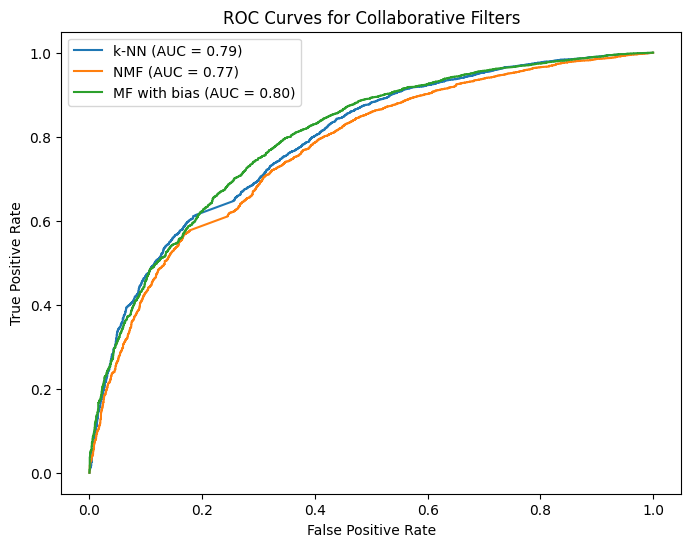

In [21]:
trainset, testset = train_test_split(ratings_data, test_size=0.1)
mf_predictions  = SVD(n_factors=k_val_rmse_mf,n_epochs=20,verbose=False).fit(trainset).test(testset)
nmf_predictions  = NMF(n_factors=k_val_rmse_nmf,n_epochs=50,verbose=False).fit(trainset).test(testset)
knn_predictions = KNNWithMeans(k=k_val_rmse,sim_options={'name':'pearson'},verbose=False).fit(trainset).test(testset)

# Compute ROC curve and AUC for k-NN
knn_true_labels = [1 if pred.r_ui >= 3 else 0 for pred in knn_predictions]
knn_predicted_scores = [pred.est for pred in knn_predictions]
knn_fpr, knn_tpr, _ = roc_curve(knn_true_labels, knn_predicted_scores)
knn_auc = auc(knn_fpr, knn_tpr)

# Compute ROC curve and AUC for NMF
nmf_true_labels = [1 if pred.r_ui >= 3 else 0 for pred in nmf_predictions]
nmf_predicted_scores = [pred.est for pred in nmf_predictions]
nmf_fpr, nmf_tpr, _ = roc_curve(nmf_true_labels, nmf_predicted_scores)
nmf_auc = auc(nmf_fpr, nmf_tpr)

# Compute ROC curve and AUC for MF with bias
mf_true_labels = [1 if pred.r_ui >= 3 else 0 for pred in mf_predictions]
mf_predicted_scores = [pred.est for pred in mf_predictions]
mf_fpr, mf_tpr, _ = roc_curve(mf_true_labels, mf_predicted_scores)
mf_auc = auc(mf_fpr, mf_tpr)

# Plot ROC curves
plt.figure(figsize=(8, 6))
plt.plot(knn_fpr, knn_tpr, label=f'k-NN (AUC = {knn_auc:.2f})')
plt.plot(nmf_fpr, nmf_tpr, label=f'NMF (AUC = {nmf_auc:.2f})')
plt.plot(mf_fpr, mf_tpr, label=f'MF with bias (AUC = {mf_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Collaborative Filters')
plt.legend()
plt.show()

QUESTION 12:
Comparing the most performant models across architecture: Plot the best ROC curves (threshold = 3) for the k-NN, NMF, and MF with bias based collaborative filters in the same figure. Use the figure to compare the performance of the filters in predicting the ratings of the movies.

> The above figure shows the ROC Curve for k-NN, NMF and MF based collaborative Filtering. We can see that MF performs the best and has the highest AUC followed by k-NN and then NMF. SVD is better able to represent the higher dimensional feature matrix as it does not have any constraints on U and V and thus provides a better factorization with much less information loss. Whereas NMF imposes certain conditions on U and V and hence we have less number of optimal choices. SVD produces embeddings of features with high relevance. This is done in a hierarchical manner. Therefore it is ordered in terms of relevance. Therefore for a high value of k, the embeddings do not hinder the model. Therefore they are robust to outliers and are not that affected by noise as compared to NMF. On the other hand k-NN predicts directly on the sparse rating matrix. This is why it has a poor prediction accuracy on higher dimensions. K-NN models are hence more difficult to scale. kNN is more sensitive to outliers.